# Pre-processing Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from datetime import datetime
import numpy as np

In [169]:
CM_SCORE = pd.read_csv('elix_score.csv',index_col=0)
DM = pd.read_csv('DMChartEvents.csv',usecols=["hadm_id", "subject_id", "itemid", "charttime","valuenum"])
DM = DM.sort_values(by=['charttime'])
Admissions = pd.read_csv('Admissions.csv',index_col=2)
Patients = pd.read_csv('Patients.csv',index_col=1)

In [3]:
hadm_id = []
subject_id = []
for index,row in DM.iterrows():
    if(row['hadm_id'] not in hadm_id):
        hadm_id.append(row['hadm_id'])
        subject_id.append(row['subject_id'])

In [170]:
d = {'hadm_id': hadm_id, 'subject_id': subject_id}
finalDF = pd.DataFrame(data=d)
finalDF['expire_flag'] = 0

In [171]:
for index,row in finalDF.iterrows():
    expire_flag = Admissions.loc[row['hadm_id'],'HOSPITAL_EXPIRE_FLAG']
    finalDF.at[index,'expire_flag'] = expire_flag

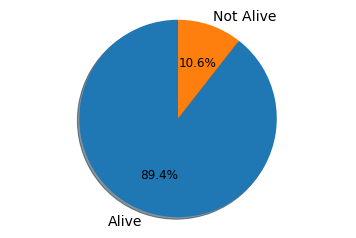

Alive:  12217
Not Alive:  1443


<Figure size 432x288 with 0 Axes>

In [172]:
alive = 0
dead = 0
for index,row in finalDF.iterrows():
    if(row['expire_flag'] == 1):
        dead = dead+1
    else:
        alive = alive+1
        
labels = 'Alive', 'Not Alive'
sizes = [alive,dead]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()
print("Alive: ", alive)
print("Not Alive: ", dead)
plt.savefig('mortality_distribution.png')

In [174]:
finalDF['admission_type'] = ''
for index,row in finalDF.iterrows():
    admission_type = Admissions.loc[row['hadm_id'],'ADMISSION_TYPE']
    finalDF.at[index,'admission_type'] = admission_type

In [175]:
finalDF['elix_score'] = 0
for index,row in finalDF.iterrows():
    elix_score = CM_SCORE.loc[row['hadm_id'],'elixhauser_vanwalraven']
    if(np.isnan(elix_score)):
        elix_score = 0
    finalDF.at[index,'elix_score'] = elix_score

In [176]:
finalDF['age'] = 0
for index,row in finalDF.iterrows():
    birth = Patients.loc[row['subject_id'],'DOB']
    birth = datetime.strptime(birth, '%Y-%m-%d %H:%M:%S')
    birth_year = birth.year
    current = Admissions.loc[row['hadm_id'],'ADMITTIME']
    current = datetime.strptime(current, '%Y-%m-%d %H:%M:%S')
    current_year = current.year
    age = current_year-birth_year
    finalDF.at[index,'age'] = age

In [177]:
glucoseNumbers = {}
for index,row in DM.iterrows():
    glucoseNumbers.setdefault(row['hadm_id'], []).append(row['valuenum'])

In [178]:
finalDF['glucose'] = np.array
for index,row in finalDF.iterrows():
    glucose = glucoseNumbers[row['hadm_id']]
    finalDF.at[index,'glucose'] = glucose

In [179]:
from sklearn.preprocessing import LabelEncoder

In [180]:
le_admission_type = LabelEncoder()
finalDF['admission_type_encoded'] = le_admission_type.fit_transform(finalDF.admission_type)


In [185]:
glucose_count_A = {}
glucose_count_D = {}
for index,row in finalDF.iterrows():
    glucose_list = row['glucose']
    if(row['expire_flag'] == 0):
        glucose_count_A[index] = 0
        for num in glucose_list:
            glucose_count_A[index] += 1
    else:
        glucose_count_D[index] = 0
        for num in glucose_list:
            glucose_count_D[index] += 1

In [186]:
num_readings_A = {}
num_readings_D = {}

for key,value in glucose_count_A.items():
    if(value in num_readings_A):        
        num_readings_A[value] += 1
    else:
        num_readings_A[value] = 1
        
for key,value in glucose_count_D.items():
    if(value in num_readings_D):        
        num_readings_D[value] += 1
    else:
        num_readings_D[value] = 1
    

In [187]:
#N will change the max amount of numbers for visual purposes
N=60
num=np.arange(N)
occurA = []
occurD = []

for x in num:
    if x in num_readings_A:
        occurA.append(num_readings_A[x])
    else:
        occurA.append(0)

for x in num:
    if x in num_readings_D:
        occurD.append(num_readings_D[x])
    else:
        occurD.append(0)

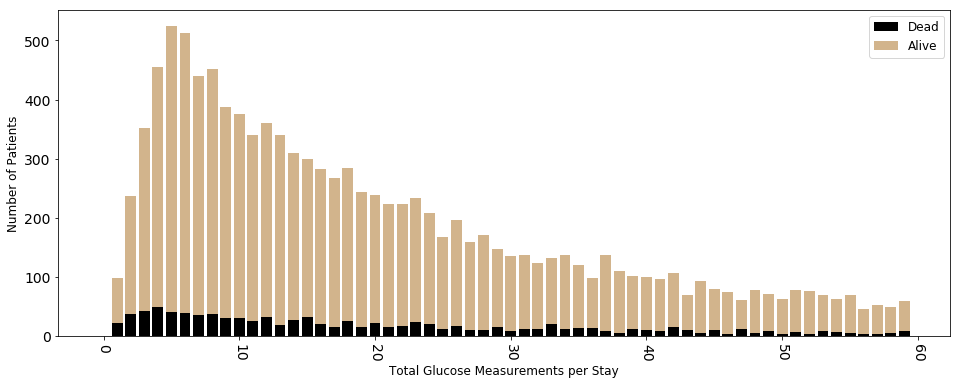

In [188]:
plt.figure(figsize=(16, 6))
plt.rcParams.update({'font.size':12})
plt.ylabel('Number of Patients')
plt.xlabel('Total Glucose Measurements per Stay')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.xticks(rotation=270)
p1 = plt.bar(num,occurD,color='black')
p2 = plt.bar(num,occurA,bottom=occurD,color='tan')
plt.legend((p1[0], p2[0]), ('Dead', 'Alive'))
plt.savefig('glucose_distribution.png')
plt.show()


In [189]:
finalDF['glucose_readings'] = 0
glucose_dict = {}
for index,row in finalDF.iterrows():
    glucose_list = row['glucose']
    glucose_readings = len(glucose_list)
    finalDF.at[index,'glucose_readings'] = glucose_readings
    num = index
    if (len(glucose_list) < 30): 
        for glu in reversed(glucose_list):        
            glucose_dict.setdefault(num, []).append(glu)  
    else:
        for i in range(1,31):
            glucose_dict.setdefault(num, []).append(glucose_list[(len(glucose_list)-i)])

In [191]:
glucoseDF = pd.DataFrame.from_dict(glucose_dict, orient='index')

In [192]:
finalDF = finalDF.join(glucoseDF)

In [198]:
def Average(lst): 
    return sum(lst) / len(lst)

In [199]:
for index,row in finalDF.iterrows():
    glucose_list = row['glucose']
    glucose_list = np.array(glucose_list)
    glucose_list = glucose_list[np.logical_not(np.isnan(glucose_list))]
    if(glucose_list.size<=0):
        #finalDF.loc[index,'mean'] = 0
        finalDF.loc[index,'range'] = 0
    else:
        glucose_list = glucose_list.astype(int)
        #mean = Average(glucose_list)
        maxval = max(glucose_list)
        minval = min(glucose_list)
        #finalDF.loc[index,'mean'] = int(mean)
        finalDF.loc[index,'range'] = (maxval - minval)

for index,row in finalDF.iterrows():
    if(row['range'] == 0):
        finalDF.drop([index])
    

In [200]:
finalDF = finalDF.fillna(0)

In [202]:
#Can determine how many patients are completely full with glucose readings
full = 0
not_full = 0
for index,row in finalDF.iterrows():
    if(row[17] == 0):
        not_full += 1
    else:
        full += 1
print('full: ',full)
print('not_full: ',not_full)
        

full:  7556
not_full:  6104


In [204]:
finalDF.to_csv('finalDF.csv', mode='w')